**Instituto Tecnológico de Aeronáutica – ITA**

**Inteligência Artificial para Robótica Móvel – CT-213**

**Professores:** 

Marcos Ricardo Omena de Albuquerque Maximo

André Oliveira Françani


# Laboratório 9 – Detecção de Objetos

# 1.	Introdução
 
Nesse laboratório, seu objetivo é implementar um algoritmo de detecção de objetos do futebol de robôs com base no algoritmo de YOLO (*You Only Look Once*), que por sua vez se baseia no uso de uma Rede Neural Convolucional (RNC). A Figura 1 mostra detecção de objetos (bola e traves) com uso desse algoritmo. A implementação do algoritmo em questão no futebol de robôs foi realizado na Iniciação Científica do aluno Lucas Steuernagel da COMP-21. O professor gostaria de agradecer imensamente ao Lucas por ter fornecido código e várias explicações que foram essenciais para implementação desse laboratório. Pode-se dizer que o Lucas garantiu 90% do lab.



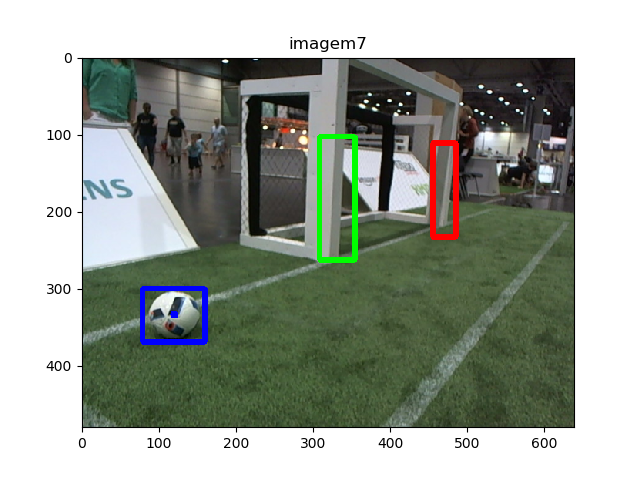

**Figura 1**: detecção de objetos do futebol de robôs através do algoritmo de YOLO.

# 2. Descrição do Problema

O problema a ser resolvido nesse laboratório é detectar objetos do ambiente do futebol de robôs através de uma versão modificada do algoritmo YOLO. No caso, usar-se-á o mesmo esquema apresentado em sala para detecção da bola e das traves no futebol de robôs. O algoritmo de YOLO divide a imagem em várias células (quadrados) conforme mostra a Figura 2.


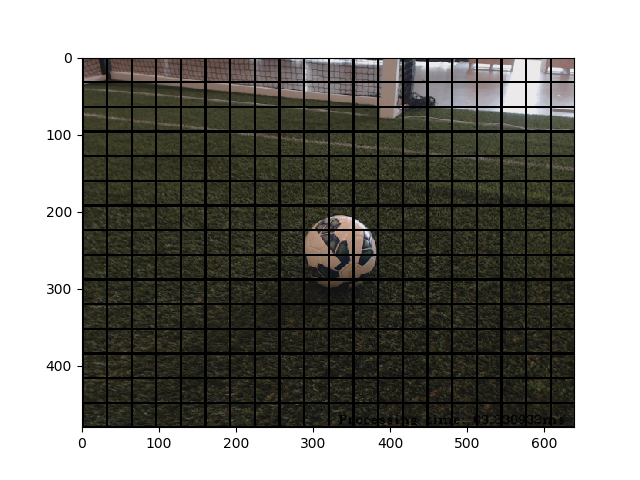

**Figura 2**: ideia do YOLO de dividir imagem em células.

No caso da implementação da ITAndroids para o futebol de robôs, define-se o seguinte vetor de features para cada célula:

$$ x = [t_b, t_{xb}, t_{yb}, w_b, h_b, t_p, t_{xp}, t_{py}, w_p, h_p]^T$$

em que:

- $t_b$: probabilidade da bola estar presente no quadrado.
- $(t_{xb}, t_{yb})$: posição xy do centro da bola dentro do quadrado.
- $(t_{wb}, t_{hb})$: largura e altura da *bounding box* da bola, respectivamente.
- $t_p$: probabilidade da trave estar presente no quadrado.
- $(t_{xp}, t_{yp})$: posição xy do centro da *bounding box* da trave dentro do quadrado.
- $(t_{wp}, t_{hp})$: largura e altura da *bounding box* da trave, respectivamente.

No caso da implementação da ITAndroids, a imagem original capturada pela câmera do robô é de 640x480 pixels (largura x altura). Para reduzir o custo computacional da rede, a imagem tem sua resolução reduzida para 160x120 (redução para 1/4 do tamanho original em cada dimensão) antes de ser passada para a rede. A partir dessa imagem 160x120, a versão adaptada de YOLO divide a imagem em 20x15 células de 8x8 pixels cada (equivalente a 32x32 pixels na imagem original de 640x480). Assim como é feito no YOLO v2, o vetor de *features* apresenta valores que são normalizados fora da rede pelas seguintes fórmulas:

$$ p_b = \sigma(t_b)$$

$$ x_b = (j_b + \sigma(t_{xb})) * s_{coord}$$

$$ y_b = (i_b + \sigma(t_{yb})) * s_{coord}$$

$$ w_b = 640 * p_{wb} * \exp(t_{wb})$$

$$ h_b = 640 * p_{hb} * \exp(t_{hb})$$

$$ p_p = \sigma(t_p)$$

$$ x_p = (j_p + \sigma(t_{xp})) * s_{coord}$$

$$ y_p = (i_p + \sigma(t_{yp})) * s_{coord}$$

$$ w_p = 640 * p_{wp} * \exp(t_{wp})$$

$$ h_p = 640 * p_{hp} * \exp(t_{hp})$$

em que:

- $(i_b,j_b)$: índices da célula no tabuleiro de YOLO (no caso, $i$ se refere a linha e $j$ a coluna).
- $s_{coord}$: fator de escala para converter do espaço normalizado da YOLO (em que cada dimensão dentro de uma célula vai de 0 a 1) para o espaço de pixels da imagem. No caso considerado, deseja-se dar resposta do algoritmo já considerando a resolução total da imagem, de 640x480, logo deve-se usar $s_{coord} = 8*4$.
- $(p_{wb},p_{hb})$: tamanho da *anchor box* da bola. No caso da ITAndroids, usa-se $(p_{wb}, p_{hb}) = (5,5)$.
- $(p_{wp}, p_{hp})$: tamanho da *anchor box* da trave. No caso da ITAndroids, usa-se $(p_{wp}, p_{hp}) = (2,5)$.

Finalmente, destaca-se que a rede utilizada nesse algoritmo tem a arquitetura apresentada na Figura 3. A Tabela 1 mostra um sumário da rede, com mais detalhes sobre cada camada. Perceba que há uma *skip connection* (característica de “*Residual Networks*”, mas implementada com uma concatenação) da saída da camada 6 para a entrada da camada 8.

Com exceção da camada 7B (*skip connection*), todas as camadas convolucionais tem tamanho de kernel de (3, 3), usam *stride* de (1, 1) e *padding* de forma a manter a mesma largura e altura do volume convolucional de entrada. A convolução da camada 7B tem tamanho de *kernel* de (1, 1), *stride* de (1, 1) e *padding* de forma a manter a mesma largura e altura do volume convolucional. As camadas de *max poolings* de 3 a 5 tem tamanho do *kernel* de (2, 2) e *stride* de (2, 2). Já o *max pooling* da camada 6 tem *kernel* de (2, 2), mas *stride* de (1, 1). Para verificar que isso é verdade, perceba na Tabela 1 que os *max poolings* das camadas de 3 a 5 fazem *downsample* da imagem, enquanto o da camada 6 não faz. Não use *bias* nas camadas que usam *batch normalization* (camadas 1 a 8, incluindo a *skip connection*), pois o *batch normalization* naturalmente trata do *bias*. Perceba que a última camada convolucional não tem *batch normalization*, então use *bias* apenas nessa camada convolucional.

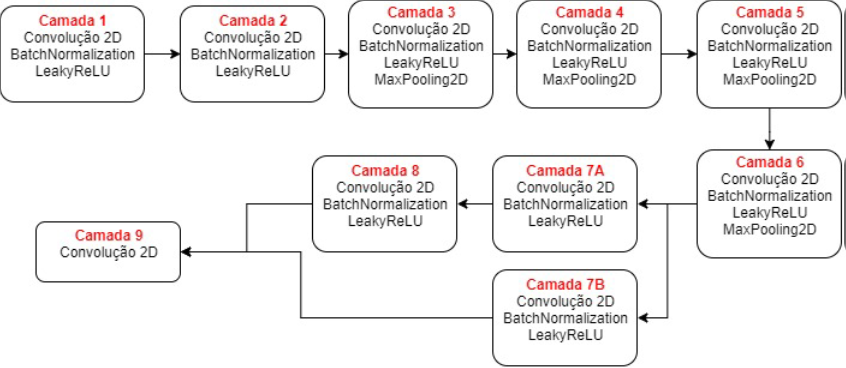

**Figura 3**: diagrama da arquitetura da rede usada para detecção de objetos no futebol de robôs.



|***Layer (type)*** |   ***Output Shape***   |   ***Param #***   |  ***Connected to*** |
|:------------|:-----------------|:------------|:--------------|
|input_1 (InputLayer)     |       (None, 120, 160, 3) |0   | - |
|conv_1 (Conv2D)          |       (None, 120, 160, 8) | 216 |   input_1[0][0]|
|norm_1 (BatchNormalization)  |   (None, 120, 160, 8) | 32    |      conv_1[0][0] |
|leaky_relu_1 (LeakyReLU)    |    (None, 120, 160, 8) | 0       |    norm_1[0][0] |
|conv_2 (Conv2D)         |        (None, 120, 160, 8) | 576    |     leaky_relu_1[0][0]|
|norm_2 (BatchNormalization)   |  (None, 120, 160, 8) | 32      |    conv_2[0][0]|
|leaky_relu_2 (LeakyReLU)    |    (None, 120, 160, 8) | 0    |       norm_2[0][0]|
|conv_3 (Conv2D)         |        (None, 120, 160, 16) | 1152   |     leaky_relu_2[0][0]|
|norm_3 (BatchNormalization)   |  (None, 120, 160, 16) | 64    |      conv_3[0][0]|
|leaky_relu_3 (LeakyReLU)   |     (None, 120, 160, 16) | 0    |       norm_3[0][0]|
|max_pool_3 (MaxPooling2D)   |    (None, 60, 80, 16)  | 0     |      leaky_relu_3[0][0]|
|conv_4 (Conv2D)        |         (None, 60, 80, 32) |  4608    |    max_pool_3[0][0]|
|norm_4 (BatchNormalization)  |   (None, 60, 80, 32) |  128   |      conv_4[0][0]|
|leaky_relu_4 (LeakyReLU)   |     (None, 60, 80, 32) |  0     |      norm_4[0][0]|
|max_pool_4 (MaxPooling2D)   |    (None, 30, 40, 32) |  0     |      leaky_relu_4[0][0]|
|conv_5 (Conv2D)       |          (None, 30, 40, 64) |  18432   |    max_pool_4[0][0]    |
norm_5 (BatchNormalization)  |   (None, 30, 40, 64) |  256     |    conv_5[0][0] |
leaky_relu_5 (LeakyReLU)    |    (None, 30, 40, 64) |  0      |     norm_5[0][0] |
max_pool_5 (MaxPooling2D)    |   (None, 15, 20, 64)  | 0       |    leaky_relu_5[0][0] |
conv_6 (Conv2D)        |         (None, 15, 20, 64) |  36864   |    max_pool_5[0][0]|
norm_6 (BatchNormalization)  |   (None, 15, 20, 64)  | 256    |     conv_6[0][0] |
leaky_relu_6 (LeakyReLU)    |    (None, 15, 20, 64) |  0       |    norm_6[0][0]|
max_pool_6 (MaxPooling2D)   |    (None, 15, 20, 64) |  0    |       leaky_relu_6[0][0] |
conv_7 (Conv2D)         |        (None, 15, 20, 128) | 73728   |    max_pool_6[0][0]|
norm_7 (BatchNormalization)   |  (None, 15, 20, 128) | 512    |     conv_7[0][0]  |
leaky_relu_7 (LeakyReLU)    |    (None, 15, 20, 128) | 0      |     norm_7[0][0] |
conv_skip (Conv2D)      |        (None, 15, 20, 128) | 8192   |     max_pool_6[0][0]  |
conv_8 (Conv2D)      |           (None, 15, 20, 256) | 294912   |   leaky_relu_7[0][0] |
norm_skip (BatchNormalization) | (None, 15, 20, 128) | 512    |     conv_skip[0][0] |
norm_8 (BatchNormalization)  |   (None, 15, 20, 256) | 1024   |     conv_8[0][0]  |
leaky_relu_skip (LeakyReLU)   |  (None, 15, 20, 128) | 0    |       norm_skip[0][0] |
leaky_relu_8 (LeakyReLU)  |      (None, 15, 20, 256) | 0     |      norm_8[0][0] |
concat (Concatenate)     |      (None, 15, 20, 384) | 0     |   leaky_relu_skip[0][0]   <br> leaky_relu_8[0][0] <br> |
conv_9 (Conv2D)          |       (None, 15, 20, 10) |  3850     |   concat[0][0]     |
| | | | |
========================<br>Total params: 445,346 <br> Trainable params: 443,938 <br> Non-trainable params: 1,408 <br>========================|
|

**Tabela 1**: sumário da arquitetura da rede usada para detecção de objetos no futebol de robôs.

Para treinar sua habilidade de usar Keras para criar uma rede maior que as exercitadas nos laboratórios anteriores, você vai criar o modelo da rede em Keras. Porém, como o treinamento da rede demora muito (cerca de 8h em GPU), você não fará o treinamento.

Então, em outra parte da implementação do laboratório, você carregará a rede usada pelo robô Chape da ITAndroids já treinada. Com isso, ficará responsável por implementar a parte do algoritmo de YOLO que trata a saída da rede neural para encontrar a posição central dos objetos e as dimensões da *bounding box*. Além disso, você também implementará código necessário para adaptar a imagem da câmera do robô para a entrada esperada pela rede.



# 3. Código Base

O código base tem uma função para você implementar a rede em Keras: a função  `make_detector_network`. Então, se você rodar esse código, ele imprimirá um sumário do seu modelo, semelhante ao mostrado na Tabela 1. Tente fazer com que seu sumário fique exatamente igual ao mostrado na Tabela 1, inclusive com o mesmo nome para cada uma das camadas. Veja as dicas no final do roteiro para te ajudar na implementação.

Para a inferência usando o algoritmo YOLO, você deve implementar os métodos `detect()`, `preprocess_image()` e `process_yolo_output()` da classe `YoloDetector`:

- `detect()`: é o método geral, que é chamada externamente a essa classe. A entrada dese método é a imagem em 640x480x3 em formato RGB. Esse método usa a predição da rede e os métodos `preprocess_image()` e `process_yolo_output()` para realizar a detecção.

- `preprocess_image()`: esse método adapta a imagem original para o formato esperado pela rede neural. Em suma, deve-se redimensionar a imagem para 160x120, então fazer com que cada valor de cor se torne um *float* entre 0 e 1 (ao invés de *int* de 0 a 255) e finalmente dar *reshape* para um *array* de NumPy no formato (1, 120, 160, 3). Perceba que a rede espera 120 linhas por 160 colunas por 3 canais de cores (em geral, fala-se de imagem como largura x altura, mas como um *array* uma imagem é altura x largura, pois largura e altura se referem a números de colunas e linhas, respectivamente).

- `process_yolo_output()`: esse método processa a saída da rede, que com os parâmetros usados fica no formato (1, 15, 20, 10), i.e. 10 *features* para cada célula, sendo que são 20x15 células (a primeira dimensão se refere a cada entrada usada na inferência, mas usaremos sempre uma única imagem na predição). 

    - Para a bola, você deve pegar a célula com maior probabilidade de presença da bola e fazer as devidas transformações nas *features*, conforme explicado na seção anterior. 
    - Para a trave, você deve pegar as células com maior e segunda maior probabilidades de presença de trave. Então, deve transformar as *features* dessas duas candidatas de trave. 
  
  A saída desse método são as detecções candidatas: a da bola e as duas da trave. Cada detecção é uma tupla de 5 dimensões com as seguintes informações: $(p_*, x_*, y_*, w_*, h_*)$.


# 4. Tarefas


Inicie o laboratório fazendo o *download* das imagens de teste da YOLO e da rede já treinada (*yolo_ball_goalpost.hdf5*).

In [ ]:
import zipfile
import os

# Download data (MUST RUN)
!gdown --id 1q1REcYazSz6_gJstLIaAC-0FF4w_SOwJ

with zipfile.ZipFile("lab9_ct213_2022.zip","r") as zip_ref:
  zip_ref.extractall() # extracts in current directory

# make results folder to save images
if not os.path.exists('results'):
  os.makedirs('results')
  
os.remove("lab9_ct213_2022.zip")

## 4.1. Implementação do Modelo da Rede Neural

Primeiramente, você deve implementar o modelo em Keras da rede neural. Faça isso na função `make_detector_network()`. Siga a mesma arquitetura mostrada na Tabela 1, **inclusive use os mesmos nomes para cada camada**. Também atente bem para a correta configuração dos hiperparâmetros de cada camada. Caso fique com dúvidas, consulte o professor. Para verificar se o modelo está correto, compare o sumário impresso com o mostrado na Tabela 1. Coloque no relatório o sumário do seu modelo.


In [ ]:
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import os


def make_detector_network(img_cols, img_rows):
    """
    Makes the convolutional neural network used in the object detector.

    :param img_cols: number of columns of the input image.
    :param img_rows: number of rows of the input image.
    :return: Keras' model of the neural network.
    """
    # Input layer
    input_image = Input(shape=(img_cols, img_rows, 3))

    # Layer 1
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
    layer = BatchNormalization(name='norm_1')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_1')(layer)

    # Todo: Implement layers 2 to 5

    # Layer 6
    layer = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_6')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_6')(layer)
    layer = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same', name='max_pool_6')(layer)

    skip_connection = layer

    # Todo: Implement layers 7A, 8, and 7B

    # Concatenating layers 7B and 8
    layer = concatenate([skip_connection, layer], name='concat')

    # Layer 9 (last layer)
    layer = Conv2D(10, (1, 1), strides=(1, 1), padding='same', name='conv_9', use_bias=True)(layer)

    model = Model(inputs=input_image, outputs=layer, name='ITA_YOLO')

    return model


model = make_detector_network(120, 160)
model.summary()  # prints the network summary

## 4.2. Implementação da Detecção de Objetos com YOLO

Implemente os métodos `detect()`, `preprocess_image()` e `process_yolo_output()` da classe `YoloDetector`. Veja dicas no final do roteiro.

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

def sigmoid(x):
    """
    Computes the sigmoid activation function.

    :param x: input value.
    :type x: float.
    :return: output value.
    :rtype: float.
    """
    return 1.0 / (1.0 + np.exp(-x))

class YoloDetector:
    """
    Represents an object detector for robot soccer based on the YOLO algorithm.
    """
    def __init__(self, model_name, anchor_box_ball=(5, 5), anchor_box_post=(2, 5)):
        """
        Constructs an object detector for robot soccer based on the YOLO algorithm.

        :param model_name: name of the neural network model which will be loaded.
        :type model_name: str.
        :param anchor_box_ball: dimensions of the anchor box used for the ball.
        :type anchor_box_ball: bidimensional tuple.
        :param anchor_box_post: dimensions of the anchor box used for the goal post.
        :type anchor_box_post: bidimensional tuple.
        """
        self.network = load_model(model_name + '.hdf5')
        self.network.summary()  # prints the neural network summary
        self.anchor_box_ball = anchor_box_ball
        self.anchor_box_post = anchor_box_post

    def detect(self, image):
        """
        Detects robot soccer's objects given the robot's camera image.

        :param image: image from the robot camera in 640x480 resolution and RGB color space.
        :type image: OpenCV's image.
        :return: (ball_detection, post1_detection, post2_detection), where each detection is given
                by a 5-dimensional tuple: (probability, x, y, width, height).
        :rtype: 3-dimensional tuple of 5-dimensional tuples.
        """
        # Todo: implement object detection logic
        ball_detection = (0.0, 0.0, 0.0, 0.0, 0.0)  # Todo: remove this line
        post1_detection = (0.0, 0.0, 0.0, 0.0, 0.0)  # Todo: remove this line
        post2_detection = (0.0, 0.0, 0.0, 0.0, 0.0)  # Todo: remove this line
        return ball_detection, post1_detection, post2_detection

    def preprocess_image(self, image):
        """
        Preprocesses the camera image to adapt it to the neural network.

        :param image: image from the robot camera in 640x480 resolution and RGB color space.
        :type image: OpenCV's image.
        :return: image suitable for use in the neural network.
        :rtype: NumPy 4-dimensional array with dimensions (1, 120, 160, 3).
        """
        # Todo: implement image preprocessing logic
        return image

    def process_yolo_output(self, output):
        """
        Processes the neural network's output to yield the detections.

        :param output: neural network's output.
        :type output: NumPy 4-dimensional array with dimensions (1, 15, 20, 10).
        :return: (ball_detection, post1_detection, post2_detection), where each detection is given
                by a 5-dimensional tuple: (probability, x, y, width, height).
        :rtype: 3-dimensional tuple of 5-dimensional tuples.
        """
        coord_scale = 4 * 8  # coordinate scale used for computing the x and y coordinates of the BB's center
        bb_scale = 640  # bounding box scale used for computing width and height
        output = np.reshape(output, (15, 20, 10))  # reshaping to remove the first dimension
        # Todo: implement YOLO logic
        ball_detection = (0.0, 0.0, 0.0, 0.0, 0.0)  # Todo: change this line
        post1_detection = (0.0, 0.0, 0.0, 0.0, 0.0)  # Todo: change this line
        post2_detection = (0.0, 0.0, 0.0, 0.0, 0.0)  # Todo: change this line
        return ball_detection, post1_detection, post2_detection


## 4.3. Teste da Implementação YOLO

Por fim, a sua implementação da inferência com YOLO em 10 imagens diferentes. Coloque no relatório algumas imagens geradas com as detecções destacadas (escolha umas 5 imagens). Comente os resultados obtidos. Ignore o fato de que algumas camadas da rede carregada tem nomes diferentes dos que são exibidos na Tabela 1, tentei deixar os nomes mais didáticos para facilitar sua implementação do item anterior 😀.

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import time

NUM_IMAGES = 10
DETECTION_THRESHOLD = 0.5  # probability threshold used to discard object detections
# Used for plotting purposes
RECT_THICKNESS = 5
CIRCLE_RADIUS = 5
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)


def load_image(image_name):
    """
    Loads an image.

    :param image_name: image name.
    :type image_name: str.
    :return: loaded image.
    :rtype: OpenCV's image.
    """
    exists = os.path.isfile(image_name + '.jpg')
    if exists:
        return cv2.imread(image_name + '.jpg')
    else:
        return cv2.imread(image_name + '.png')


def show_detection(image, detection, color, show_center=False):
    """
    Shows an object detection.

    :param image: image used for object detection.
    :type image: OpenCV's image.
    :param detection: detection as a 5-dimensional tuple: (probability, x, y, width, height).
    :type detection: 5-dimensional tuple.
    :param color: color used to show the detection (RGB value).
    :type color: 3-dimensional tuple.
    :param show_center: if the center of the detection should be shown in the image.
    :type show_center: bool.
    """
    x = detection[1]
    y = detection[2]
    width = detection[3]
    height = detection[4]
    top_left = (int(x - width / 2), int(y - height / 2))
    bottom_right = (int(x + width / 2), int(y + height / 2))
    cv2.rectangle(image, top_left, bottom_right, color, RECT_THICKNESS)
    if show_center:
        cv2.circle(image, (int(x), int(y)), CIRCLE_RADIUS, color, -1)


def show_detections(image_name, image, ball_detection, post1_detection, post2_detection):
    """
    Shows the image with all relevant detections.

    :param image_name: image name used for the plot's title.
    :type image_name: str.
    :param image: image used for object detection.
    :type image: OpenCV's image.
    :param ball_detection: ball_detection as a 5-dimensional tuple: (probability, x, y, width, height).
    :type ball_detection: 5-dimensional tuple.
    :param post1_detection: first goal post detection as a 5-dimensional tuple: (probability, x, y, width, height).
    :type post1_detection: 5-dimensional tuple.
    :param post2_detection: second goal post detection as a 5-dimensional tuple: (probability, x, y, width, height).
    :type post2_detection: 5-dimensional tuple.
    """
    if ball_detection[0] >= DETECTION_THRESHOLD:
        show_detection(image, ball_detection, BLUE, True)
    if post1_detection[0] >= DETECTION_THRESHOLD:
        show_detection(image, post1_detection, GREEN)
    if post2_detection[0] >= DETECTION_THRESHOLD:
        show_detection(image, post2_detection, RED)
    plt.figure()
    plt.imshow(image)
    plt.title(image_name)


# Creating the object detector
detector = YoloDetector('yolo_ball_goalpost')
inference_time = []
# Iterating over images, running the detector and showing the detections
for i in range(1, NUM_IMAGES + 1):
    image_name = 'imagem' + str(i)
    image = load_image(image_name)
    # Converting color space since OpenCV loads images as BGR and our network as trained with RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tic = time.time()
    ball_detection, post1_detection, post2_detection = detector.detect(image)
    toc = time.time()
    inference_time.append(toc-tic)
    print(image_name + ': [(ball_prob: ' + str(ball_detection[0]) + ', post1_prob: ' + str(post1_detection[0]) +
          ', post2_prob: ' + str(post2_detection[0]) + '), processing time: ' + str(toc - tic) + ']')
    show_detections(image_name, image, ball_detection, post1_detection, post2_detection)
    plt.savefig('results/' + image_name + '_detection.png')

print('Inferences time: ', inference_time)
print('Mean inference time: ', sum(inference_time)/len(inference_time))
plt.show()

# 5. Entrega

A entrega consiste do notebook no formato .ipynb e de um relatório, submetida através do Google Classroom. Modificações nos arquivos do código base são permitidas, desde que o nome e a interface dos scripts “main” não sejam alterados. A princípio, não há limitação de número de páginas para o relatório, mas pede-se que seja sucinto. O relatório deve conter:

- Breve descrição em alto nível da sua implementação.
- Figuras que comprovem o funcionamento do seu código.

Por limitações do Google Classroom (e por motivo de facilitar a automatização da correção), entregue seu laboratório com todos os arquivos num único arquivo **.zip** (**não** utilize outras tecnologias de compactação de arquivos) com o seguinte padrão de nome: **“<login_email_google_education>_labX.zip”**. Por exemplo, no meu caso, meu login Google Education é **marcos.maximo**, logo eu entregaria o lab 9 como **“marcos.maximo_lab9.zip”**. **Não** crie subpastas para os arquivos da sua entrega, **deixe todos os arquivos na “raiz” do .zip**. Os relatórios devem ser entregues em formato **.pdf**.

# 6.	Dicas

- Uma outra forma de implementar camadas em Keras é ir passar uma camada como entrada da outra camada. Por exemplo, a implementação da camada 1 da rede YOLO da ITAndroids pode ser implementada da seguinte forma:
```python
input_image = Input(shape=(img_cols, img_rows, 3))
layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
layer = BatchNormalization(name='norm_1')(layer)
layer = LeakyReLU(alpha=0.1, name='leaky_relu_1')(layer)
```

- Já a camada 6 é implementada da seguinte forma:
```python
layer = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(layer)
layer = BatchNormalization(name='norm_6')(layer)
layer = LeakyReLU(alpha=0.1, name='leaky_relu_6')(layer)
layer = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same', name='max_pool_6')(layer)
```
em que nesse último trecho de código, o primeiro *layer* que aparece se refere ao *max pooling* da camada 5.

- Destacamos os seguintes parâmetros na configuração de cada camada:
  - `padding='same'` faz com que seja adicionado *padding* de modo a manter a mesma resolução do volume de entrada.
  -	`name='layer_name'` configura o nome da camada.
  -	`use_bias=False` faz com que não sejam adicionados termos de *bias* nessa camada.

- Para implementar a “*skip connection*”, você precisa guardar a “saída” da sexta camada em outra variável, então seguir a definição da camada “paralela” (7B) com essa nova variável. Ao final, concatenar as saídas de 7B e 8 em uma nova “camada”, que será entrada da última camada. Em código, deve fazer algo assim:
``` python
# Layer 6
(...)
layer = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same', name='max_pool_6')(layer)
# Implement layers 7A, 8, and 7B
#
# Concatenating layers 7B and 8
layer = concatenate([skip_connection, layer], name='concat')
# Layer 9 (last layer)
layer = Conv2D(10, (1, 1), strides=(1, 1), padding='same', name='conv_9', use_bias=True)(layer)
```
- Durante suas implementações, tome cuidado pois OpenCV usa notação (largura, altura) para representar dimensão de imagem, enquanto no NumPy e no Keras você usará (altura, largura). Infelizmente, isso é uma confusão comum quando se trabalha com imagens. Isso vem do fato de que normalmente pensamos em (largura, altura) para imagens, conforme a convenção de (x, y) de eixos coordenadas, mas em (linhas, colunas) quando falamos de matriz. Devido a isso, tome cuidado com o que é índice de matriz (e naturalmente estará na notação (linha, coluna) ou (y, x)) e o que é coordenada de imagem (que estará na notação (x, y) ou (coluna, linha)).

- Para fazer *downsample* em uma imagem com OpenCV, use:
``` python
image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
```

- Assim que a imagem tiver sido reduzida, transforme-a em um array de NumPy:
```python
image = np.array(image)
```

- Para normalizar a imagem, use a seguinte operação do NumPy (percebeu-se que iterar sobre os elementos e normalizar um a um resulta em resultado inadequado, pois o NumPy mantém cada elemento com tipo uint8):
```
image = image / 255.0
```

- Para dar reshape no array de NumPy:
```
image = np.reshape(image, (1, 120, 160, 3))
```

- Para fazer o download das figuras e usá-las no relatório, use os seguintes comandos:
```python
from google.colab import files
import os
os.system('zip -r lab9_results.zip results')
files.download("lab9_results.zip")
```
